### Generating human faces with Adversarial Networks


In [4]:
#!L
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
plt.rcParams.update({'axes.titlesize': 'small'})

import torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.utils import make_grid

use_cuda = torch.cuda.is_available()

print("Torch version:", torch.__version__)
if use_cuda:
    print("Using GPU")
else:
    print("Not using GPU")

Torch version: 2.4.1+cu124
Using GPU


### Prepare Dataset

In [5]:
#!L
class CropCelebA64:
    
    def __call__(self, pic):
        new_pic = pic.crop((15, 40, 178 - 15, 218 - 30))
        return new_pic

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [6]:
train_dataset = torchvision.datasets.CelebA(
    root='C:/Users/Николай/PycharmProjects/ml2023/labGenDcv/celeba',
    split='train',
    transform=torchvision.transforms.Compose([
        CropCelebA64(),
        torchvision.transforms.Resize(64),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        
        torchvision.transforms.Grayscale()
    ]),
)

IMG_SHAPE = tuple(train_dataset[0][0].shape)

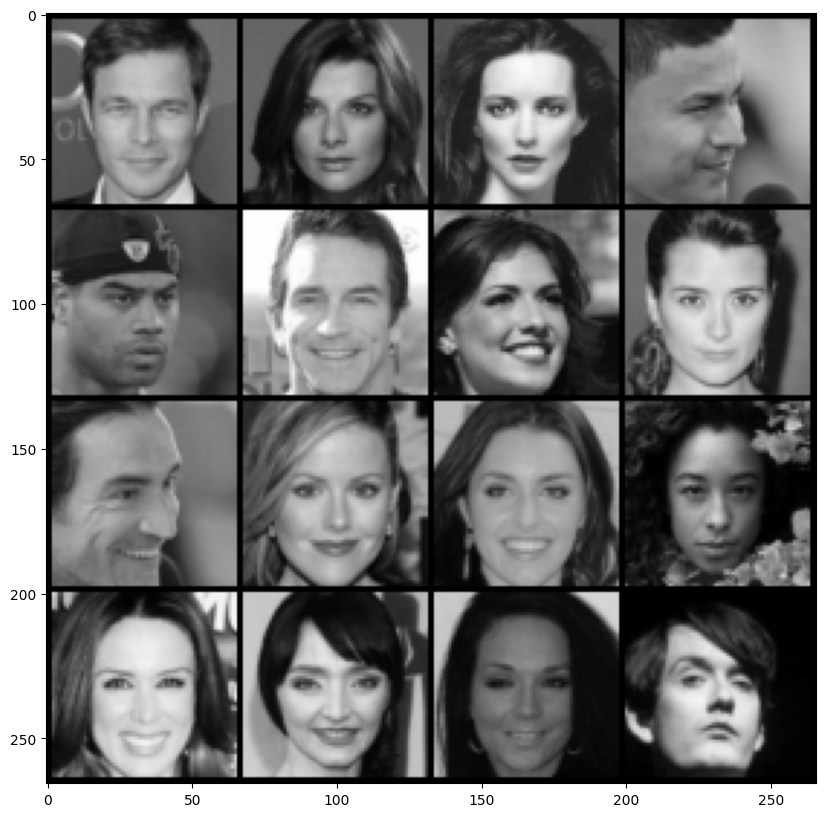

In [7]:
samples = torch.stack([train_dataset[i][0] for i in range(32, 48)], dim=0)

plt.figure(figsize=(10, 10))
plt.imshow(make_grid(samples, nrow=4).permute(1, 2, 0))
plt.show()

# Generative adversarial nets 101

<img src="https://raw.githubusercontent.com/torch/torch.github.io/master/blog/_posts/images/model.png" width=320px height=240px>

In [8]:
#!L
def sample_noise_batch(batch_size):
    noise = torch.randn(batch_size, CODE_SIZE)
    return noise.cuda() if use_cuda else noise.cpu()
    
class Reshape(nn.Module):
    def __init__(self, shape):
        nn.Module.__init__(self)
        self.shape = shape
    
    def forward(self,input):
        return input.view(self.shape)

In [145]:
#!L
CODE_SIZE = 100

generator = nn.Sequential()


generator.add_module('linear1', nn.Linear(CODE_SIZE, 10*8*8))
generator.add_module('act1', nn.LeakyReLU())
generator.add_module('reshape1', Reshape([-1, 10, 8, 8]))

generator.add_module('conv2', nn.ConvTranspose2d(10, 64, kernel_size=(5,5))) #12
generator.add_module('act2', nn.LeakyReLU())
generator.add_module('conv3', nn.ConvTranspose2d(64, 64, kernel_size=(5,5))) #16
generator.add_module('act3', nn.LeakyReLU())
generator.add_module('pool1', nn.Upsample(scale_factor=2)) #32
generator.add_module('conv4', nn.ConvTranspose2d(64, 32, kernel_size=(3,3))) #34
generator.add_module('act4', nn.LeakyReLU())
generator.add_module('pool2', nn.Upsample(scale_factor=2)) #68
generator.add_module('convf', nn.Conv2d(32, 1, kernel_size=(3,3))) #66
generator.add_module('convf_1', nn.Conv2d(1, 1, kernel_size=(3,3))) #64
##TODO: define next layers

if use_cuda: generator.cuda()

In [146]:
#!L
generated_data = generator(sample_noise_batch(5))
assert tuple(generated_data.shape)[1:] == IMG_SHAPE, "generator must output an image of shape %s, but instead it produces %s"%(IMG_SHAPE, tuple(generated_data.shape)[1:])

### Discriminator


In [147]:
def sample_data_batch(batch_size):
    idxs = np.random.choice(np.arange(len(train_dataset)), size=batch_size)
    batch = torch.stack([train_dataset[idx][0] for idx in idxs], dim=0)
    return batch.cuda() if use_cuda else batch.cpu()

class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.shape[0], -1)

In [159]:
discriminator = nn.Sequential()


discriminator.add_module("conv1", nn.Conv2d(1, 16, kernel_size=7)) # 58
discriminator.add_module("act1", nn.LeakyReLU())
discriminator.add_module("conv2", nn.Conv2d(16, 16, kernel_size=7)) # 52
discriminator.add_module("act2", nn.LeakyReLU())
discriminator.add_module("avgpool1", nn.AvgPool2d(2, stride=2)) # 26
discriminator.add_module("conv3", nn.Conv2d(16, 32, kernel_size=5)) # 22
discriminator.add_module("act3", nn.LeakyReLU())
discriminator.add_module("avgpool2", nn.AvgPool2d(2, stride=2)) # 11
discriminator.add_module("conv5", nn.Conv2d(32, 64, kernel_size=5)) # 7
discriminator.add_module("act5", nn.LeakyReLU())
discriminator.add_module("conv4", nn.Conv2d(64, 64, kernel_size=3)) # 5
discriminator.add_module("act4", nn.LeakyReLU())
discriminator.add_module("flatten", nn.Flatten())
discriminator.add_module("linear", nn.Linear(64*25, 256))
discriminator.add_module("act6", nn.Tanh())
discriminator.add_module("disc_logit", nn.Linear(256, 1))

if use_cuda: discriminator.cuda()

In [160]:
sample_data_batch(4).shape

torch.Size([4, 1, 64, 64])

In [161]:
#!L
discriminator(sample_data_batch(4))

tensor([[-0.0077],
        [-0.0079],
        [-0.0077],
        [-0.0081]], device='cuda:0', grad_fn=<AddmmBackward0>)

# Training

In [162]:
def generator_loss(noise):
    """
    1. generate data given noise
    2. compute log P(real | gen noise)
    3. return generator loss (should be scalar)
    """
    generated_data = generator(noise)
    
    disc_on_generated_data = discriminator(generated_data)
    
    logp_gen_is_real = F.logsigmoid(disc_on_generated_data)
    
    loss = -logp_gen_is_real.mean()
    
    return loss

In [163]:
loss = generator_loss(sample_noise_batch(32))

print(loss)

assert len(loss.shape) == 0, "Loss must be scalar"

tensor(0.6978, device='cuda:0', grad_fn=<NegBackward0>)


In [164]:
def discriminator_loss(real_data, generated_data):
    """
    1. compute discriminator's output on real & generated data
    2. compute log-probabilities of real data being real, generated data being fake
    3. return discriminator loss (scalar)
    """
    disc_on_real_data = discriminator(real_data)
    disc_on_fake_data = discriminator(generated_data)
    
    logp_real_is_real = F.logsigmoid(disc_on_real_data)
    logp_gen_is_fake = F.logsigmoid(-disc_on_fake_data)
    
    loss = -(logp_real_is_real.mean() + logp_gen_is_fake.mean())
    return loss

In [165]:
loss = discriminator_loss(sample_data_batch(32), 
                   generator(sample_noise_batch(32)))

print(loss)

assert len(loss.shape) == 0, "Loss must be scalar"

tensor(1.3856, device='cuda:0', grad_fn=<NegBackward0>)


### Auxilary functions


In [166]:
#!L
def sample_images(nrow, ncol, sharp=False):
    images = generator(sample_noise_batch(batch_size=nrow*ncol))
    images = images.data.cpu().numpy().transpose([0, 2, 3, 1])
    if np.var(images)!=0:
        images = images.clip(0, 1)
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(images[i], cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i], cmap="gray")
    plt.show()

def sample_probas(batch_size):
    plt.title('Generated vs real data')
    D_real = torch.sigmoid(discriminator(sample_data_batch(batch_size)))
    generated_data_batch = generator(sample_noise_batch(batch_size))
    D_fake = torch.sigmoid(discriminator(generated_data_batch))
    
    plt.hist(D_real.data.cpu().numpy(),
             label='D(x)', alpha=0.5, range=[0,1])
    plt.hist(D_fake.data.cpu().numpy(),
             label='D(G(z))', alpha=0.5, range=[0,1])
    plt.legend(loc='best')
    plt.show()

### Training
Main loop.


In [167]:
disc_opt = torch.optim.SGD(discriminator.parameters(), lr=5e-3)
gen_opt = torch.optim.Adam(generator.parameters(), lr=1e-4)

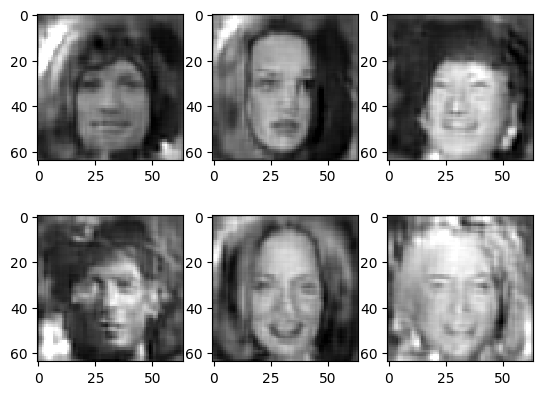

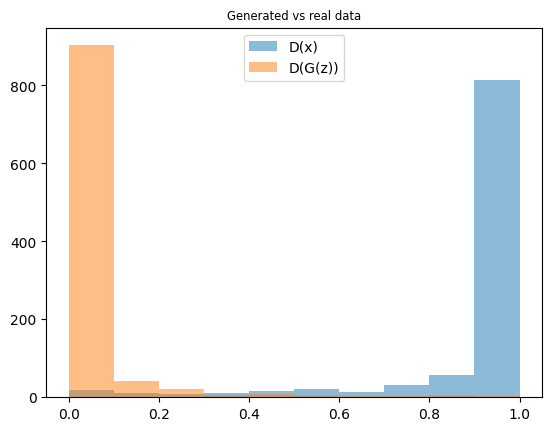

In [168]:
from IPython import display
from tqdm.auto import tqdm

batch_size = 100
loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

for epoch in range(30):
    for iteration, (batch, _) in tqdm(enumerate(loader)):

        # Train discriminator
        real_data = batch.cuda() if use_cuda else batch.cpu()
        fake_data = generator(sample_noise_batch(batch_size))
        loss = discriminator_loss(real_data, fake_data)
        disc_opt.zero_grad()
        loss.backward()
        disc_opt.step()

        # Train generator
        if iteration % 5 == 0:
            noise = sample_noise_batch(batch_size)
            loss = generator_loss(noise)
            gen_opt.zero_grad()
            loss.backward()
            gen_opt.step()

        if iteration % 100 == 0:
            print(epoch)
            display.clear_output(wait=True)
            sample_images(2,3,True)
            sample_probas(1000)
        

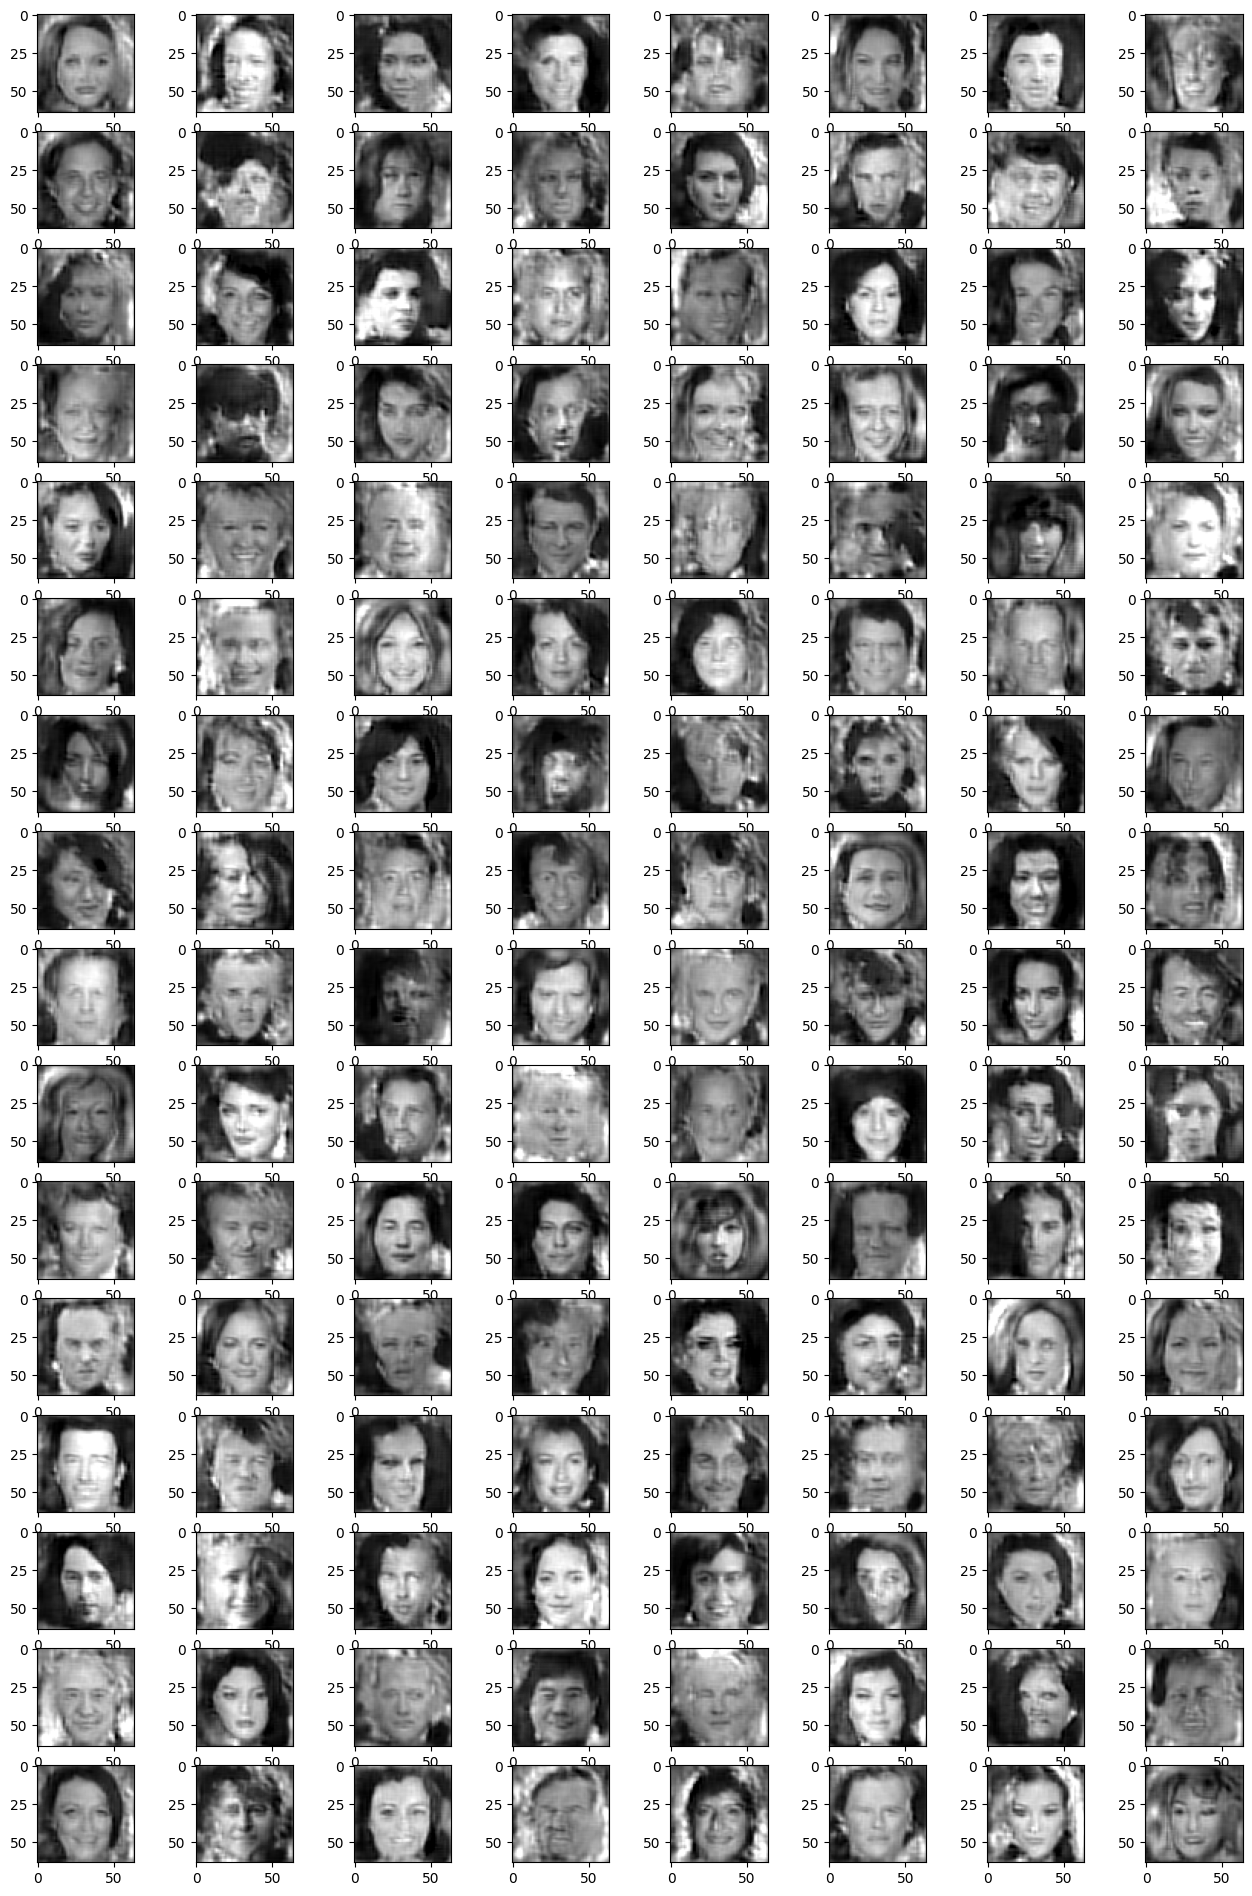

In [169]:
plt.figure(figsize=[16, 24])
sample_images(16, 8)
